In [1]:
from typing import List, Callable

import numpy as np
import torch as t
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import animation, cm, cbook

from tqdm.notebook import tqdm

In [7]:
def U_paraboloid(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    x_hat = x - np.array([a, b])
    return c * x_hat.dot(x_hat)

def grad_U_paraboloid(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    x_hat = x - np.array([a, b])
    return 2 * c * x_hat

def U_valley(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return c * (x[0]-a)**2

def grad_U_valley(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return 2 * c * (x[0]-a)

def U_crossing_2(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return c * min((x[0]-a)**2, (x[1]-b)**2)

def grad_U_crossing_2(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    if (x[0]-a)**2 < (x[1]-b)**2:
        return np.array([
            2 * c * (x[0] - a),
            0.,
        ])
    else:
        return np.array([
            0.,
            2 * c * (x[1] - b),
        ])

    # return np.array([
    #     2 * c * max((x[0] - a), 0.),
    #     2 * c * max((x[1] - b), 0.),
    # ])

def U_crossing_4(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return c * min((x[0]-a)**2, (x[1]-b)**2, (x[0] + x[1])**2, (x[0] - x[1])**2)

def grad_U_crossing_4(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    return np.array([
        2 * c * max((x[0] - a), 0., 2 * (x[0] + x[1]), 2 * (x[0] - x[1])),
        2 * c * max((x[1] - b), 0.,  2 * (x[0] + x[1]), 2 * (x[0] - x[1])),
    ])

def U(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1., regularization=0.):
    # return U_paraboloid(x, a=a, b=b, c=c)
    return U_crossing_2(x, a=a, b=b, c=c) + 0.5 * regularization * np.linalg.norm(x - np.array([-1., -1.])) ** 2
    # return U_crossing_4(x, a=a, b=b, c=c)

def grad_U(x: np.ndarray, a: float = 0., b: float = 0., c: float = 1.):
    # return grad_U_paraboloid(x, a=a, b=b, c=c)
    return grad_U_crossing_2(x, a=a, b=b, c=c)
    # return grad_U_crossing_4(x, a=a, b=b, c=c)

def get_U_contour(a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1), regularization=0.):
    x = np.linspace(xlim[0], xlim[1], 1000)
    y = np.linspace(ylim[0], ylim[1], 1000)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = U(np.array([X[i, j], Y[i, j]]), a=a, b=b, c=c, regularization=regularization)

            if zlim and Z[i, j] > zlim:
                Z[i, j] = np.nan

    return X, Y, Z

def get_stationary_dist_contour(a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1), beta=1.):
    x = np.linspace(xlim[0], xlim[1], 100)
    y = np.linspace(ylim[0], ylim[1], 100)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            potential = U(np.array([X[i, j], Y[i, j]]), a=a, b=b, c=c)
            Z[i, j] = np.exp(-beta * potential)

            if zlim and Z[i, j] > zlim:
                Z[i, j] = np.nan

    return X, Y, Z

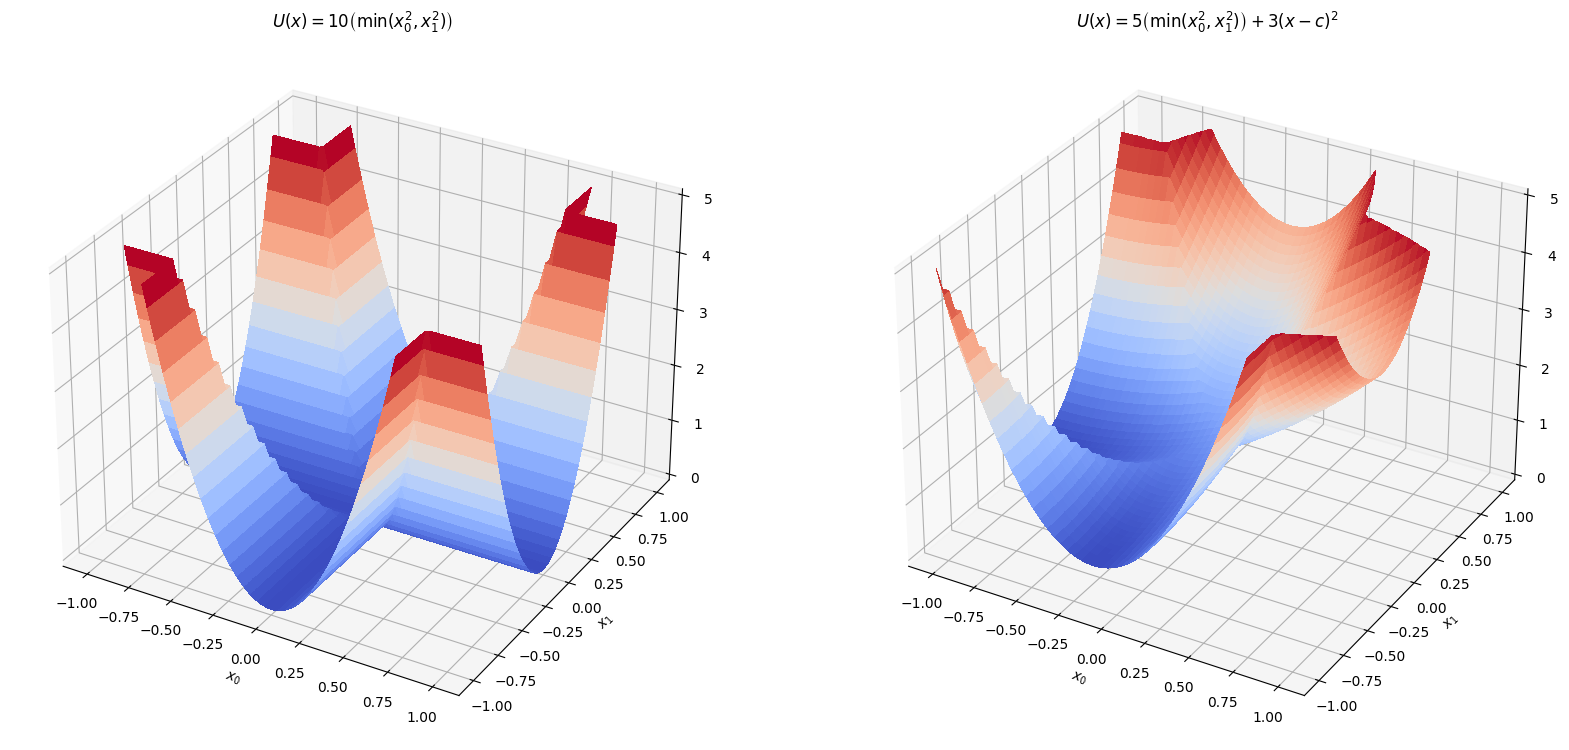

In [8]:
def plot_U_3D(a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1), ax=None, regularization=0.):
    X, Y, Z = get_U_contour(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim, regularization=regularization)

    # In 3D
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Max height = 1
    if zlim:
        ax.set_zlim(0, zlim)

    ax.set_title(f"$U(x) = \min(-(x_0-{a})^2, -(x_1-{b})^2)$")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return ax


def plot_stationary_dist_3D(a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1), ax=None, beta=1.):
    X, Y, Z = get_stationary_dist_contour(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim, beta=1.)

    # In 3D
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Max height = 1
    ax.set_zlim(0, zlim)

    ax.set_title(f"$e^{{-\\beta U(x)}}$, where $\\beta={beta}$")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return ax


fig, axes = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})

ax_r0 = plot_U_3D(c=10, ax=axes[0], zlim=5.)
# plot_stationary_dist_3D(c=10, ax=axes[1])
ax_r5 = plot_U_3D(c=5, regularization=1.5, ax=axes[1], zlim=5)

ax_r0.set_title(r"$U(x) = 10\left(\min(x_0^2, x_1^2)\right)$")
ax_r5.set_title(r"$U(x) = 5\left(\min(x_0^2, x_1^2)\right) + 3(x - c)^2$")

plt.show()

In [9]:
def plot_U_2D(a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1)):
    X, Y, Z = get_U_contour(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.contour(X, Y, Z, levels=20, cmap=cm.coolwarm)
    ax.set_title(f"$H(x, v) = U(x) + K(v)$\n$U(x) = \min(-(x_0-{a})^2, -(x_1-{b})^2)$")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return fig, ax

def plot_walk_2D(walk: np.ndarray, a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1)):
    fig, ax = plot_U_2D(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim)

    # Break apart the walk into sections that don't involve wrapping around the torus
    # I.e.: split at large jumps
    split_indices = np.where(np.linalg.norm(walk[1:] - walk[:-1], axis=1) > 0.5)[0] + 1
    split_indices = np.concatenate(([0], split_indices, [len(walk)]))

    for i in range(len(split_indices) - 1):
        start = split_indices[i]
        end = split_indices[i + 1]

        ax.plot(walk[start:end, 0], walk[start:end, 1], color='black', linewidth=0.5, alpha=0.1)
        ax.scatter(walk[start:end, 0], walk[start:end, 1], color='black', s=5, alpha=0.1)
    
    return fig, ax

In [10]:
def leapfrog_update(x, p, epsilon=1e-6):
    p -= epsilon * grad_U(x) / 2.
    x += epsilon * p
    p -= epsilon * grad_U(x) / 2.
    return x, p

def wrap_torus(x, xlim, ylim):
    x[0] = (x[0] - xlim[0]) % (xlim[1] - xlim[0]) + xlim[0]
    x[1] = (x[1] - ylim[0]) % (ylim[1] - ylim[0]) + ylim[0]
    
    return x

def simulate_particle(
    a = 0., 
    b = 0., 
    c: float = 1., 
    x0: np.ndarray = np.array([0., 0.]), 
    epsilon: float = 1e-3,
    dt: float = 0.1, 
    n_steps: int = 1000, 
    xlim=(-1., 1.), 
    ylim=(-1., 1.)
):
    x = x0
    xs = [x]

    E_old = U(x, a=a, b=b, c=c)

    for i in tqdm(range(n_steps), desc="Simulating particle..."):
        # Hamiltonian Monte Carlo
        x_new = x.copy()
        p = np.random.normal(0, 1, size=2)
        K = p @ p / 2.

        E_old = U(x, a=a, b=b, c=c) + K

        # Leapfrog integration
        for i in range(int(dt // epsilon)):
            x_new, p = leapfrog_update(x_new, p, epsilon=epsilon)
                
        x_new = wrap_torus(x_new, xlim=xlim, ylim=ylim)

        # Gibbs sampling step
        K_new = p @ p / 2.
        E_new = U(x_new, a=a, b=b, c=c) + K_new

        if np.random.uniform() < np.exp(-(E_new - E_old)):
            x = x_new
            
        xs.append(x)        

    return np.array(xs)

xs = simulate_particle(dt=1, epsilon=0.001, x0=np.array([0., 0.]), n_steps=10_000, c=1000.)

# plot_walk_2D(xs, c=1, xlim=(-1, 1), ylim=(-1, 1))

Simulating particle...:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
from scipy.stats import gaussian_kde

def plot_empirical_dist_3D(walk: np.ndarray, a=0., b=0., c: float = 1, zlim=1., xlim=(-1, 1), ylim=(-1, 1), ax=None):
    X, Y, Z = get_U_contour(a=a, b=b, c=c, zlim=zlim, xlim=xlim, ylim=ylim)

    # In 3D
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

    # Kernel density estimation
    kde = gaussian_kde(walk.T)
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    ax.set_title(f"Empirical distribution")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    
    return kde, Z, ax

walk_kde, Z, ax = plot_empirical_dist_3D(xs, c=100, xlim=(-1, 1), ylim=(-1, 1))

NameError: name 'xs' is not defined

In [ ]:
def particle_stats(xs):

    df = pd.DataFrame(np.concatenate([xs, vs], axis=1), columns=["x0", "x1", "v0", "v1"])
    df["U"] = df.apply(lambda row: U(np.array([row["x0"], row["x1"]])), axis=1)

    return df

df = particle_stats(xs)
df

[-0.25035803  0.14979667]


Simulating particle...:   0%|          | 0/100 [00:00<?, ?it/s]

[-0.62022389  0.57791388]


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_53104/79943220.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Simulating particle...:   0%|          | 0/100 [00:00<?, ?it/s]

[ 0.94390703 -0.05269889]


Simulating particle...:   0%|          | 0/100 [00:00<?, ?it/s]

[ 0.25711841 -0.78975083]


Simulating particle...:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

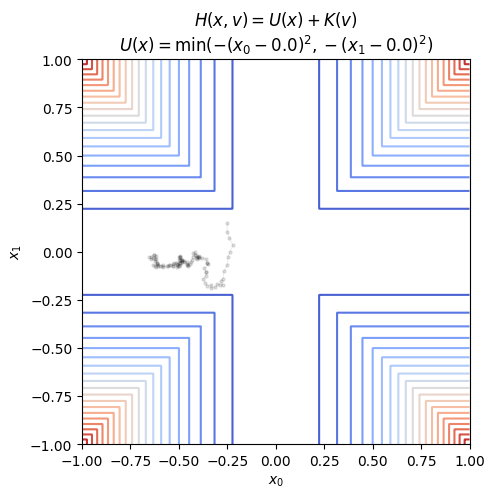

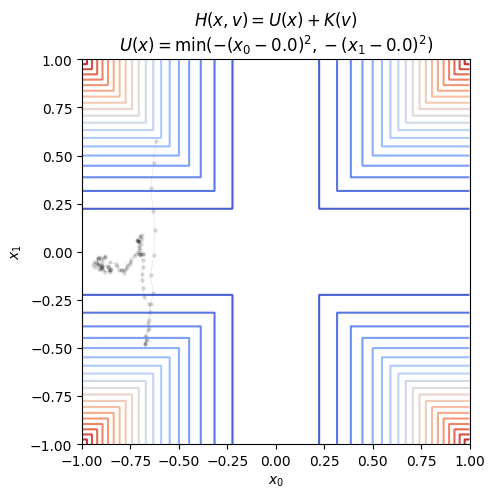

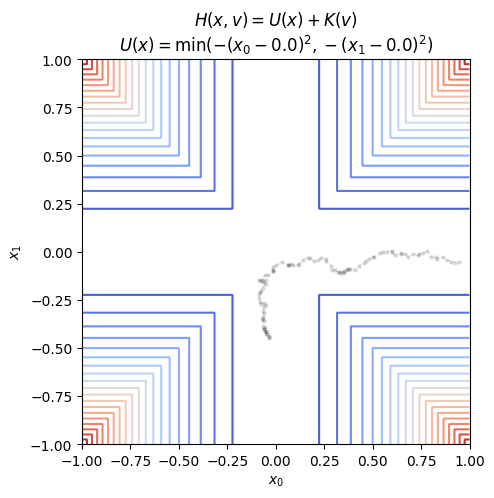

In [21]:
def potential_sgd(
    a = 0., 
    b = 0., 
    c: float = 1., 
    x0: np.ndarray = np.array([0., 0.]), 
    epsilon: float = 1e-3,
    dt: float = 0.1, 
    n_steps: int = 1000, 
    xlim=(-1., 1.), 
    ylim=(-1., 1.),
    beta=0.2,
    verbose=False,
    regularization=0.,
    regularization_center=None
):
    xs = [x0]

    p = np.zeros(2)

    progress = tqdm(range(n_steps), desc="Simulating particle...") if verbose else range(n_steps)
    
    if regularization_center is None:
        regularization_center = np.array([xlim[0], ylim[0]], dtype=np.float32)

    for i in progress:
        x_new = xs[i].copy()
        
        grad = grad_U(x_new, a=a, b=b, c=c) + regularization * (x_new - regularization_center)

        if i == 0:
            p = - grad
        else:
            p = p * beta - grad * (1 - beta)

        x_new += p * dt + np.random.normal(0, 1, size=2) * epsilon

        # Toroidal wrap
        # x_new = wrap_torus(x_new, xlim=xlim, ylim=ylim)
        xs.append(x_new)        

    return np.array(xs)

for i in range(5):
    x0 = np.random.uniform(-1, 1, size=2)
    print(x0)
    run = potential_sgd(x0=x0, epsilon=0.01, dt=0.001, n_steps=100, c=100., beta=0.9, verbose=True, regularization=10)
    fig, ax = plot_walk_2D(run, c=1, xlim=(-1., 1), ylim=(-1., 1))
    fig.show()

In [22]:
def sgd_sample(
    a = 0., 
    b = 0., 
    c: float = 1., 
    epsilon: float = 1e-3,
    dt: float = 0.1, 
    n_steps: int = 1000, 
    xlim=(-1., 1.), 
    ylim=(-1., 1.),
    beta=0.9,
    n_samples=100,
    regularization = 0.,
    regularization_center = None
):
    samples = []

    for i in tqdm(range(n_samples), desc="Sampling..."):
        x0 = np.random.uniform(xlim[0], xlim[1], size=2)  # Assumes same lmits for x and y
        run = potential_sgd(a=a, b=b, c=c, x0=x0, epsilon=epsilon, dt=dt, n_steps=n_steps, beta=beta, xlim=xlim, ylim=ylim, regularization=regularization, regularization_center=regularization_center)
        samples.append(run[-1])

    return np.array(samples)  

In [23]:
samples_r0 = sgd_sample(a=0., b=0., c=100., epsilon=0.01, dt=0.001, n_steps=100, beta=0, n_samples=10000, regularization=0.)

Sampling...:   0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
samples_r5 = sgd_sample(a=0., b=0., c=100., epsilon=0.01, dt=0.001, n_steps=100, beta=0, n_samples=10000, regularization=5.)

Sampling...:   0%|          | 0/10000 [00:00<?, ?it/s]

In [25]:
samples_noise_limit = sgd_sample(a=0., b=0., c=100., epsilon=0.1, dt=0.001, n_steps=100, beta=0, n_samples=20000)

Sampling...:   0%|          | 0/20000 [00:00<?, ?it/s]

Text(0.5, 0.92, '$a=100,\\ \\epsilon = 0.5,\\ \\lambda=0$')

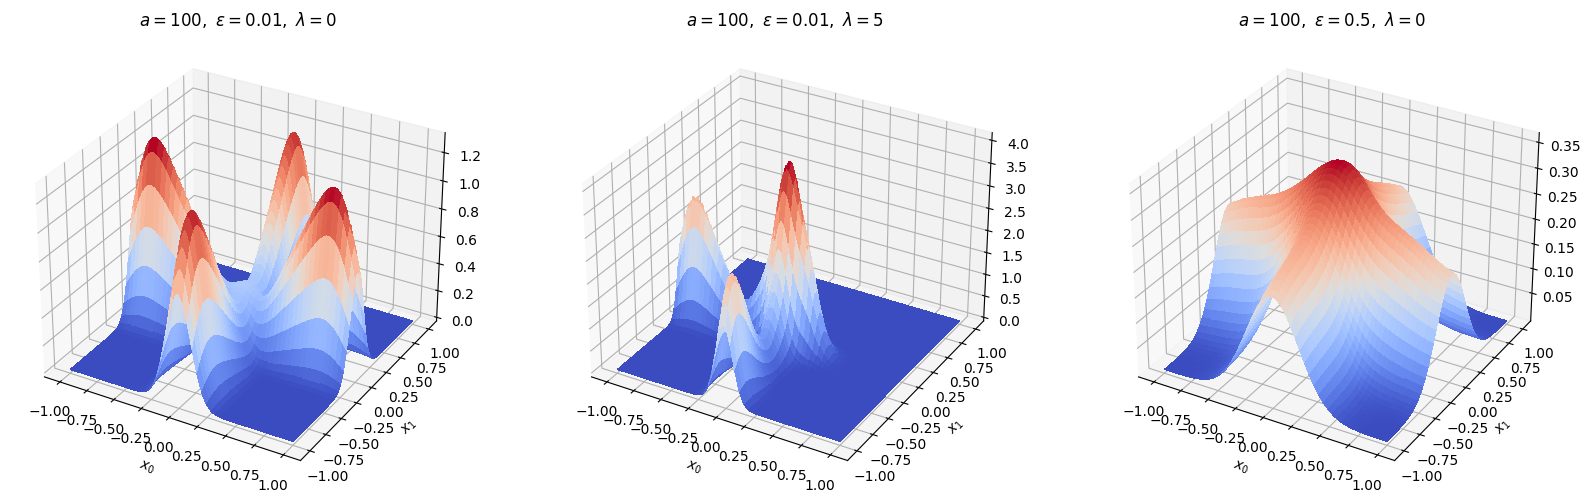

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), subplot_kw={'projection': '3d'})

walk_kde_r0, Z_r0, ax_r0 = plot_empirical_dist_3D(samples_r0, c=100., xlim=(-1, 1), ylim=(-1, 1), ax=axes[0])
walk_kde_r5, Z_r5, ax_r5 = plot_empirical_dist_3D(samples_r5, c=100., xlim=(-1, 1), ylim=(-1, 1), ax=axes[1])
walk_kde_r5, Z_r5, ax_noise_limit = plot_empirical_dist_3D(samples_noise_limit, c=100., xlim=(-1, 1), ylim=(-1, 1), ax=axes[2])

ax_r0.set_title(r"$a=100,\ \epsilon = 0.01,\ \lambda=0$")
ax_r5.set_title(r"$a=100,\ \epsilon = 0.01,\ \lambda=5$")
ax_noise_limit.set_title(r"$a=100,\ \epsilon = 0.5,\ \lambda=0$")

Text(0.5, 0.92, '$a=100,\\ \\epsilon = 0.5,\\ \\lambda=0$')

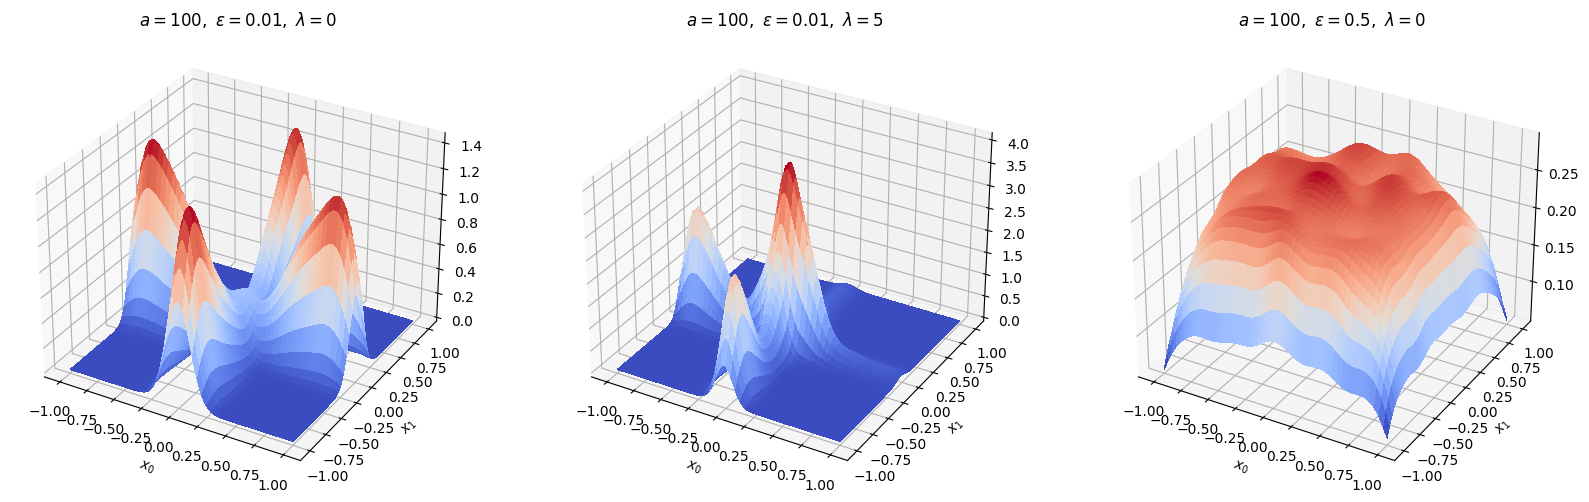

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10), subplot_kw={'projection': '3d'})

walk_kde_r0, Z_r0, ax_r0 = plot_empirical_dist_3D(samples_r0, c=100., xlim=(-1, 1), ylim=(-1, 1), ax=axes[0])
walk_kde_r5, Z_r5, ax_r5 = plot_empirical_dist_3D(samples_r5, c=100., xlim=(-1, 1), ylim=(-1, 1), ax=axes[1])
walk_kde_r5, Z_r5, ax_noise_limit = plot_empirical_dist_3D(samples_noise_limit, c=100., xlim=(-1, 1), ylim=(-1, 1), ax=axes[2])

ax_r0.set_title(r"$a=100,\ \epsilon = 0.01,\ \lambda=0$")
ax_r5.set_title(r"$a=100,\ \epsilon = 0.01,\ \lambda=5$")
ax_noise_limit.set_title(r"$a=100,\ \epsilon = 0.1,\ \lambda=0$")